# ***Progetto CV&DL - Alex Giacomini & Denis Bernovschi***

## IMPORT

In [ ]:
import sys
import subprocess
if 'google.colab' in sys.modules:
  #subprocess.call("pip install -U opencv-python".split())
  subprocess.call("pip install -U progress".split())
  
  #subprocess.call("pip install tensorflow==2.0.*".split())
  #subprocess.call("pip install keras==2.3.1".split())
  
#TensorFlow 2.0 and Keras 2.3.1 frameworks   

import pandas as pd
import random
import os
import scipy.ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers, layers
from tensorflow.keras.layers import Activation, Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical 
from PIL import Image, ImageOps
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Sequential, save_model, load_model

import matplotlib.pyplot as plt
import cv2
from random import randrange
random.seed( 40 )

print('Tensor Flow {}'.format(tf.__version__))

print('Keras {}'.format(tf.keras.__version__))


Tensor Flow 2.5.0
Keras 2.5.0


## DRIVE 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'


Mounted at /content/drive


## DATA GENERATION 

In [ ]:
import os
import pandas as pd
import numpy as np
import keras
import cv2
from google.colab.patches import cv2_imshow
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size = (270, 470),
                 shuffle = True,
                 class_weights = None):
      
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.class_weights = class_weights
        
        self.n = len(self.df)
        self.n_CLASSE_CALCIO = df[y_col['CLASSE']].nunique()
        self.classi_augmented = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

        #test di augmentation
        self.augmentor = ImageDataGenerator(
            print("[INFO] performing 'on the fly' data augmentation"),
            horizontal_flip = True,
            brightness_range = [0.2,0.5],
            preprocessing_function = None,
            fill_mode = 'constant',
            #rescale=1. / 255,
            cval = 0.0
        )

        
        if self.class_weights is not None:
          self.df2 = df.copy()
          self.class_weights = class_weights.copy()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path, target_size):
      try:
        first_char = path[0]
        if first_char != 'm':
            image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/CALCIO_CROP/'+path, color_mode="rgb" , target_size=(target_size[0],target_size[1]))
        else: 
            image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/MASK_CALCIO_CROP/'+path, color_mode="rgb", target_size=(target_size[0],target_size[1])) 
      except Exception:
        print('\n{}_not found'.format(path))
      
      image_arr = tf.keras.preprocessing.image.img_to_array(image)
      image_arr = tf.keras.applications.vgg16.preprocess_input(image_arr)               #PREPROCESSING: serve per normalizzare, quindi la rete viene addestrata per certi valori (senza preprocessing non riuscirebbe a generalizzare?)
      image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()

      return image_arr/255.     #perchè di base è tra [0 255] invece deve tornare un valore tra 0 e 1 
      #return image_arr
    
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['PATH_IMG']]  
        CLASSE_batch = batches[self.y_col['CLASSE']]

        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])
        y_batch = np.asarray([self.__get_output(y, self.n_CLASSE_CALCIO) for y in CLASSE_batch])
        classs = y_batch
        return X_batch, y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)  
        #--------eseguo Data Augmentation----------------------------------------------------------------------
        if self.class_weights is not None:
          sample_weighttt = self.__get_samples_weights_V2(y)
          X_gen = self.augmentor.flow(X, batch_size=self.batch_size, shuffle=False, sample_weight=sample_weighttt)#, save_to_dir="/content/drive/MyDrive/Augmentation")
        #  #  #X_gen=self.augmentor.flow_from_dataframe(dataframe=batches, directory="/content/drive/MyDrive/CALCIO_CROP", x_col="filename", y_col="class", batch_size=self.batch_size, 
        #  #                                         seed=42,shuffle=False,class_mode=None, sample_weight=sample_weighttt, target_size=self.input_size, classes=['1','2-','2','2+','3-','3','3+','4-','4','4+'])
          return next(X_gen), y  # - next ritorna iterativamente ogni elemento creato con l'augmentation - https://www.w3schools.com/python/ref_func_next.asp
        else:
          return X, y  #- X rappresenta l'input, y rappresenta l'output

        #return X,y
       #---------------------------------------------------------------------------------------------------------------------------------------------

    def __len__(self):
        return int(self.n) // self.batch_size

    def __get_samples_weights_V2(self, y):
          labels = []
          for x_row in y: 
            class_array = np.where(x_row == 1)
            classe_ = class_array[0]
            labels.append(classe_[0])
          
          labels_batch = np.array(labels)          
          
          class_weight_present_batch = { your_key: self.class_weights[your_key] for your_key in np.unique(labels_batch)}
          
          weights = compute_sample_weight(class_weight_present_batch,  labels_batch)
          #weights = compute_sample_weight(class_weight="balanced", y=labels_batch) 

          for your_key in np.unique(labels_batch):
            self.classi_augmented[your_key] +=1
        
          weights = np.array(weights)
          return weights


## Immagini 

In [ ]:

os.chdir('/content/drive/MyDrive/ProgettoDL/')
#from functions import preprocessing, split_data, plot_confusion_matrix, BalancedDataGenerator
# ----------------------#-----IMMAGINI----#----------------------# 
random_state = 3

parte = 'CALCIO'
tipo = 'CROP' #CROP, CROP_gray_ridge
augment = True
metaclassi = False
cnn = "vgg16" #resnet50 

#classi = ['1','2','3','3+','4']
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']
cod_componente = [ 2,  4,  8, 10,  6,  9,  3, 11, 12, 13, 14, 15,  7]

immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)
path_imgs = os.path.join(path_drive+'{}'.format(immgs))

#lettura dataset annotazioni
csv = pd.read_csv(('/content/drive/MyDrive/ProgettoDL/20201102_ExportDB.txt'), sep=";")

if 'gray' in tipo:
  colormode = "grayscale"
  print('analisi in scala di grigi')
else:
  colormode = "rgb"

## NETWORK 

In [ ]:
'''NETWORK'''

model = Sequential()
vgg16_conv = VGG16(include_top=False, weights='imagenet', input_shape=(immg_rows, immg_cols, 3))      #pre allenata con immagini di imagenet, e quindi pesi già esistenti
for layer in vgg16_conv.layers[:-1]:
    layer.trainable = False

# build top model         
x = Flatten(name='flatten')(vgg16_conv.output)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Dense(len(classi), activation='softmax', name='predictions')(x)
# stitch together
model = Model(inputs= vgg16_conv.input, outputs=x)


# inspect
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 270, 470, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 270, 470, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 270, 470, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 135, 235, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 135, 235, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 135, 235, 128)     147584    
______________________________________________________________

## Callbacks 

In [ ]:
'''CALLBACKS'''
from keras.callbacks import ModelCheckpoint, EarlyStopping
#NB: create sul drive una cartella weights dove salvare i pesi durante l'allenamento
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'
model_checkpoint = ModelCheckpoint( filepath=os.path.join('/content/drive/My Drive/ProgettoDL/weights/model_{}_{}/best_weights.h5'.format(immgs,cnn)), monitor='val_loss', verbose=1, save_best_only=True)
#early_stopping = EarlyStopping(monitor='val_loss',patience=5,verbose=1)

### MODIFICATO QUA - Implementazione Early Stopping###
#tf.keras.callbacks.EarlyStopping(patience=2)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", #Quantity to be monitored
    min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
    patience=15, #Number of epochs with no improvement after which training will be stopped
    #verbosity mode, setting verbose 0, 1 or 2 you just say 
    #how do you want to 'see' the training progress for each epoch.
    #verbose=0 will show you nothing (silent)
    #verbose=1 will show you an animated progress bar like this: progres_bar
    verbose=0, 
    #Mode = One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
    #monitored has stopped decreasing; in "max" mode 
    #it will stop when the quantity monitored has stopped increasing; 
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
    mode="auto",
    #Training will stop if the model doesn't show improvement over the baseline.
    baseline=None,
    #Whether to restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=False,
)

callbacks=[model_checkpoint ]#, early_stopping]

##HYPERPARAMETERS


The **optimization algorithm** (or optimizer) is the main approach used today for training a machine learning model to minimize its error rate. There are *two metrics* to determine the efficacy of an optimizer: **speed of convergence** (the process of reaching a global optimum for gradient descent); and **generalization** (the model’s performance on new data)

***SGD*** : Stochastic Gradient Descent 

Parameters 
- Learning : learning rate is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function. ... In setting a learning rate, there is a trade-off between the rate of convergence and overshooting
- Momentum : Momentum is method which helps accelerate gradients vectors in the right directions, thus leading to faster converging.
- Decay :  We then set our decay to be the learning rate divided by the total number of epochs we are training the network for (a common rule of thumb) ... lr = (lr_iniziale - (1.0/(1-decay*iterations)))
- Nesterov: Nesterov which is set to false by default. Nesterov momentum is a different version of the momentum method which has stronger theoretical converge guarantees for convex functions.

[1° LINK](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

[2° LINK](https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/)


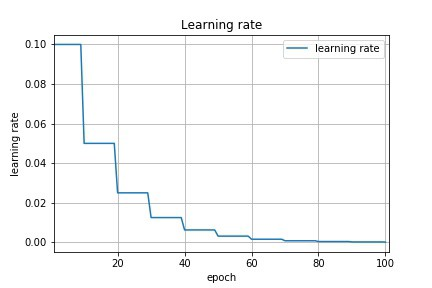

***ADAM*** :  Adaptive Moment Estimation




FONTI : Paper for ICLR 2019

In [ ]:
#Definizione hyperparameters                                                                                                                         #prova SGD

#opt = Adam(learning_rate=0.00001)
opt = SGD(learning_rate = 0.001, decay = 1e-5, momentum= 0.8)

loss='categorical_crossentropy'
num_epochs = 100 #era 100
bs = 16 #era 16 

model.compile(loss=loss, optimizer=opt, metrics = ['accuracy'])  

## SPLIT DATA

In [ ]:

#VERSIONE CON NUMERI PRESI DIRETTAMENTE DAL BILANCIAMENTO CALCOLATO RISPETTO IL TOTALE DI 2120 (che ci sono in questo progetto), PER RENDERLO DINAMICO CALCOLARE IN ALTRO MODO

#UNICO PROBLEMA È CHE A VOLTE IMMAGINI CON STESSO ID HANNO IN REALTÀ DIVERSA CLASSE DI QUALITÀ, QUINDI I DATASET NON SONO PERFETTAMENTE BILANCIATI MA VARIANO LEGGERMENTE

#-------------------------------------------------------------------------------------------------------------------------------divisione dei dati
def split_data(dataframe_result, val_size, test_size, random_state):
#data = vettore di immagini rappresentate da matrici numeriche a 3 colonne - dovrebbe diventare una data frame 
#label = vettore da 3 colonne con componenti viste in funzione preprocessing sopra
#val_size = 0.2 scelta nel codice
#test_size = 0.2 scelta nel codice
#random_state = 3 (parametro impostato nel codice)

  #unique_result = dataframe_result.nunique(axis=1) #ID - Colonna 0
  unique_result, counts = np.unique(dataframe_result['ID'], return_counts=True)
  #print('Counts')
  #print(counts)
  #print('Sto stampando...')
  #print(unique_result)
  
  
  #SE SI VUOLE CAMBIARE LA PERMUTAZIONE DEGLI ID, CAMBIARE IL RANDOM STATE!
  
  #id_perm = unique_result.iloc[np.random.permutation(unique_result.index)].reset_index(drop=True)
  id_perm = np.random.RandomState(random_state).permutation(unique_result)
  print('ID Perm : {}'.format(id_perm))
  
  #test_size = int(test_size*len(id_perm))   
  ##print('Test Size : {}'.format(test_size))                            
  #val_size = int(val_size*len(id_perm))   
  ##print('Val Size : {}'.format(val_size)) 


  #SPLIT INTO DATAFRAME 
  #test_id = id_perm[:test_size]                                         #tutti gli elementi fino al numero che corrisponde a 'test_size' del vettore id_perm che avevo permutato sopra
  #val_id = id_perm[test_size:(test_size+val_size)]                      #tutti gli elementi da indice 'test_size' fino alla somma di quelli scritti
  #train_id = id_perm[(test_size+val_size):]                             #tutti gli elementi da indice indicato, fino alla fine
  #print('TEST ID : {}'.format(test_id))  
  #print('VAL ID : {}'.format(val_id))  
  #print('TRAIN ID : {}'.format(train_id))                    
                    

  #definisco i dataframe finali 
  column_names = ['ID','series','filename','class']
  x_train = pd.DataFrame(columns = column_names)

  x_test = pd.DataFrame(columns = column_names)

  x_val = pd.DataFrame(columns = column_names)

  conta, conta0, conta1, conta2, conta3, conta4, conta5, conta6, conta7, conta8, conta9 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
  class_ = 0


  for i in id_perm:
     result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
      #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
     if result_ID[result_ID.columns[0]].count() == 2:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       row_2=result_ID.iloc[1]
       class2_ = int(row_2['class'])
       conta = 2
       #print("ID doppio")
     else:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       conta = 1
       #print("ID singolo")

     if class_ == 0 and conta0 < 100 :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 < 90 :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 < 126 :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 < 106 :
        if conta == 2 :
          x_train=x_train.append(row_1, ignore_index=True) 
          x_train=x_train.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_train=x_train.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 < 106 :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 < 184 :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 < 206 :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 < 126 :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 < 164 :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 < 64 :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= 100 and conta0 < 134 :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= 90 and conta1 < 120 :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= 126 and conta2 < 168 :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= 106 and conta3 < 142 :
        if conta == 2 :
          x_val=x_val.append(row_1, ignore_index=True) 
          x_val=x_val.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_val=x_val.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= 106 and conta4 < 142 :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= 184 and conta5 < 244 :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= 206 and conta6 < 274 :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= 126 and conta7 < 168 :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= 164 and conta8 < 218 :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= 64 and conta9 < 86 :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= 134 :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= 120 :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= 168 :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= 142 :
        if conta == 2 :
          x_test=x_test.append(row_1, ignore_index=True) 
          x_test=x_test.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_test=x_test.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= 142 :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= 244 :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= 274 :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= 168 :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= 218 :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= 86 :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1

    
  return x_train, x_test, x_val

#QUESTA VERSIONE SOTTO DIVIDE BENE PER ID, MA NON FA UNO SPLIT BILANCIATO
##vado a ricavare tutte le righe per ogni sub-set basandomi sugli indici che ne devono far parte
#  for i in test_id:                                                     
#    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
#    #print(type(result_ID))
#    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
#    row_1=result_ID.iloc[0]
#    row_2=result_ID.iloc[1]
#    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
#    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
#    x_test=x_test.append(row_1, ignore_index=True) 
#    x_test=x_test.append(row_2, ignore_index=True)
#  
#  for i in val_id:                                                     
#    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
#    #print(type(result_ID))
#    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
#    row_1=result_ID.iloc[0]
#    row_2=result_ID.iloc[1]
#    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
#    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
#    x_val=x_val.append(row_1, ignore_index=True) 
#    x_val=x_val.append(row_2, ignore_index=True)
#  
#  for i in train_id:                                                     
#    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
#    #print(type(result_ID))
#    row_1=result_ID.iloc[0]
#    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
#    row_2=result_ID.iloc[1]
#    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
#    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
#    x_train=x_train.append(row_1, ignore_index=True) 
#    x_train=x_train.append(row_2, ignore_index=True)


## PREPROCESSING & DATA FRAME 

In [ ]:
import numpy as np
from keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from sklearn.utils import class_weight

os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()

col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


dataframe_sx.columns = ['ID','series', 'filename', 'class']
dataframe_dx.columns = ['ID','series', 'filename', 'class']

#print(dataframe_sx.columns)                 #stampo i due elementi con stesso ID (lato dx e sx di stesso CALCIO)
frames = [dataframe_sx, dataframe_dx]
result = pd.concat(frames)
print(result)
print(result.loc[[1]])
print(type(result.loc[[1]]))

print("Lunghezza DataFrame complessivo : {} ".format(result[result.columns[0]].count()))

#MAPPING 
result["class"] = result["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result["series"] = result["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)})

#IDENTIFICAZIONE VALORI NULL 
print("Null VALUE di class : "+format(result['class'].isnull().sum()))
print(result.loc[result['class'] == '0'])
print(result[result['class'].isnull()])
result['class'] = pd.to_numeric(result['class'], errors='coerce')
print(result[result['class'].isnull()])
result = result.dropna(subset=['class'])    #rimuovo le righe con elementi nulli
print(result[result['class'].isnull()])

print("Null VALUE di class : "+format(result['class'].isnull().sum()))

#IMMG EXIST ?  (cerco se qualche path non esiste e lo elimino dal dataframe) e se esiste ne faccio la MASCHERA
import os.path
from os import path
os.chdir('/content/drive/MyDrive/CALCIO_CROP')
for index, row in result.iterrows():
    filename = row['filename']
    if(os.path.exists(filename) == False):
      result = result.drop(result[(result['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))                  

#print(mask_filenames)
mask_filenames = []
IDs = []
classes = []
for index, row in result.iterrows():
    filename = row['filename']
    mask_filenames.append(str("mask_"+filename))
    IDs.append(row['ID'])
    classes.append(row['class'])

print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("DATAFRAME CON MASCHERE")
result2 = result.copy()
result2['mask_filename'] = mask_filenames
result2.drop('filename', axis='columns', inplace=True)

column_names = ["ID","series", "mask_filename", "class"]

result2 = result2.reindex(columns=column_names)
print(result2)
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")


print("------------------------------ SPLIT DATA -----------------------------------------")
#CUSTOM SPLIT CON ID IN STESSO SET DI DATI
train_balance_df, test_balance_df, val_balance_df  = split_data(result2, 0.2, 0.2, 3)
#train_mask, test_mask, validation_mask  = split_data(result2, 0.2, 0.2, 3)

#train_balance_df, test_balance_df = train_test_split(result, test_size=0.4, stratify=result['class'], random_state=2)
#test_balance_df, val_balance_df = train_test_split(test_balance_df, test_size=0.5, stratify=test_balance_df['class'],random_state=2)

vals, counts = np.unique(train_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Train")
print(len(train_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts[i]))

vals2, counts2 = np.unique(val_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Validation")
print(len(val_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts2[i]))

vals3, counts3 = np.unique(test_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Test")
print(len(test_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts3[i]))    


class_weights_train = class_weight.compute_class_weight('balanced',np.unique(train_balance_df['class']),train_balance_df['class'])
weight_train = {i : round(class_weights_train[i], 2) for i in range(len(classi))} 
print('Weigh train_balance_df')
print(weight_train)


class_weights = class_weight.compute_class_weight('balanced',np.unique(val_balance_df['class']),val_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weigh val_balance_df')
print(weight)


class_weights = class_weight.compute_class_weight('balanced',np.unique(test_balance_df['class']),test_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weigh test_balance_df')
print(weight)

print("------------------------------ FINE SPLIT DATA-----------------------------------------")


        ID  series            filename class
0        3       2  20201 319 5323.png    3+
1        4       2  20201 3110125 .png    3+
2        5       2  20201 31101327.png    3+
3        6       2  20201 3110161 .png    3+
4        7       2  20201 3110177 .png    3+
...    ...     ...                 ...   ...
1059  2023       7  20201031090549.png    3+
1060  2024       7  20201031090855.png    3+
1061  2025       7  20201031091127.png    3+
1062  2026       7  20201031091720.png    3+
1063  2027       7  20201031091941.png    3+

[2128 rows x 4 columns]
   ID  series            filename class
1   4       2  20201 3110125 .png    3+
1   4       2  20201 31101226.png    3+
<class 'pandas.core.frame.DataFrame'>
Lunghezza DataFrame complessivo : 2128 
Null VALUE di class : 2
Empty DataFrame
Columns: [ID, series, filename, class]
Index: []
       ID  series            filename  class
963  1927       3  20200825181909.png    NaN
963  1927       3  20200825181932.png    NaN
       ID  se

In [ ]:
#VERIFICA DEI ID UNIVOCI IN STESSO SET

#print(train_balance_df.loc[train_balance_df['ID'] == 1868])
print(train_balance_df)
print(test_balance_df)
print(val_balance_df)


# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) >= 1 # boolean (true if there is at least 1 patient in both groups)
    
    ### END CODE HERE ###
    
    return leakage

#--------verifico che stessi ID siano in stesso set--------

# test
print("test case 1")
print(f"Stessi ID in set usati diversi?: {check_for_leakage(train_balance_df, val_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 2")
print(f"Stessi ID in set usati diversi?: {check_for_leakage(train_balance_df, test_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 3")
print(f"Stessi ID in set usati diversi?: {check_for_leakage(val_balance_df, test_balance_df, 'ID')}")

        ID series  filename  class            mask_filename
0      398      4       NaN    7.0  mask_20203 3 7 0 38.png
1      398      4       NaN    8.0  mask_20203 3 7 0 19.png
2     1944     12       NaN    6.0  mask_20201010071452.png
3     1944     12       NaN    6.0  mask_20201010071339.png
4      463      4       NaN    8.0  mask_20203 108 147 .png
...    ...    ...       ...    ...                      ...
1267  1889     11       NaN    7.0  mask_20200604132547.png
1268   265      2       NaN    5.0  mask_20202 14123442.png
1269   265      2       NaN    5.0  mask_20202 14123432.png
1270  1942     12       NaN    5.0  mask_20201010070727.png
1271  1942     12       NaN    5.0  mask_20201010070550.png

[1272 rows x 5 columns]
       ID series  filename  class            mask_filename
0     331      3       NaN    0.0  mask_20203 2 8 8 22.png
1     331      3       NaN    4.0  mask_20203 2 8 8 1 .png
2     271      3       NaN    0.0  mask_20202 2716421 .png
3     271      3   

## Testing Model 

In [ ]:
traingen = CustomDataGen(train_balance_df, X_col={'PATH_IMG':'mask_filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470), class_weights = weight_train)       #verifica weights train
testgen = CustomDataGen(test_balance_df, X_col={'PATH_IMG':'mask_filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))   
valgen = CustomDataGen(val_balance_df, X_col={'PATH_IMG':'mask_filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))

#traingen = CustomDataGen(train_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470), class_weights = weight_train)       #verifica weights train
#testgen = CustomDataGen(test_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))   
#valgen = CustomDataGen(val_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))

history = model.fit(traingen,validation_data=valgen, epochs=num_epochs, callbacks = callbacks, verbose=1)



[INFO] performing 'on the fly' data augmentation
[INFO] performing 'on the fly' data augmentation
[INFO] performing 'on the fly' data augmentation
Epoch 1/100
79/79 [==============================] - 984s 12s/step - loss: 2.7701 - accuracy: 0.2476 - val_loss: 2.4141 - val_accuracy: 0.1659

Epoch 00001: val_loss improved from inf to 2.41415, saving model to /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_CROP_vgg16/best_weights.h5
Epoch 2/100
79/79 [==============================] - 27s 317ms/step - loss: 2.1089 - accuracy: 0.3845 - val_loss: 2.2355 - val_accuracy: 0.2404

Epoch 00002: val_loss improved from 2.41415 to 2.23554, saving model to /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_CROP_vgg16/best_weights.h5
Epoch 3/100
79/79 [==============================] - 25s 316ms/step - loss: 1.9097 - accuracy: 0.4193 - val_loss: 2.4439 - val_accuracy: 0.1562

Epoch 00003: val_loss did not improve from 2.23554
Epoch 4/100
79/79 [==============================] - 25s 318ms

In [ ]:
print("Conta del numero di immagini per specifica classe in set Train")
print(traingen.classi_augmented)

Conta del numero di immagini per specifica classe in set Train
{0: 3400, 1: 4301, 2: 5201, 3: 4901, 4: 3800, 5: 5701, 6: 6301, 7: 5401, 8: 5901, 9: 2900}


## PLOT 

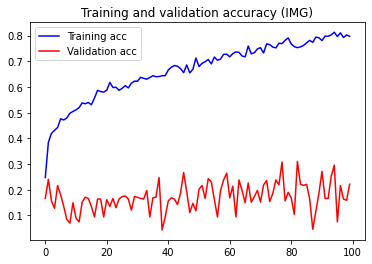

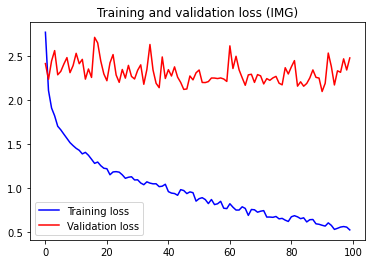

In [ ]:
'''PLOT CURVES'''

path = path_drive+'ProgettoDL/'

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
lista = [acc,val_acc,loss,val_loss]


#print(corr(history.history['accuracy'], history_mask.history_mask['accuracy']))

import csv

with open("VGG16.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lista)
     
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotAcc_{}_{}.pdf'.format(immgs,cnn))) 

plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotLoss_{}_{}.pdf'.format(immgs,cnn)))

### SAVE MODEL 

In [ ]:
#salvataggio modello pesi finali
from tensorflow.keras.models import Sequential, save_model, load_model
path = path_drive+'ProgettoDL/'
model.save(os.path.join(path+'weights/model_{}_{}/Final'.format(immgs,cnn)))
print("Saved model to disk")

INFO:tensorflow:Assets written to: /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_CROP_vgg16/Final/assets
Saved model to disk


## LOAD MODEL 

In [ ]:
'''TEST'''
import os
from tensorflow.keras.models import Sequential, save_model, load_model
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

parte = 'CALCIO'
tipo = 'CROP' #CROP, CROP_gray_ridge
augment = True
metaclassi = False
cnn = "vgg16" #resnet50 

#classi = ['1','2','3','3+','4']
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']

immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)

path_model = os.path.join(path+'weights/model_{}_{}/Final'.format(immgs,cnn))

model = load_model(path_model)
print('Model IMG Loaded')


Model IMG Loaded


## PREDICTION 

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras import Model
from keras.applications.vgg16 import preprocess_input

test_array = []
test_array_series = []

for index, row in test_balance_df.iterrows():
    class_ = int(row['class'])
    series_ = int(row['series'])          #---da qui e nei prossimi, calcolo la ground thruth del shotgun series, ovvero i semplici COD_COMPONENTE (serie) che appartengono al sub-set di test
    test_array.append(class_)
    test_array_series.append(series_)     #---

test_array = np.array(test_array)
test_array_series = np.array(test_array_series)   #---

y_test = to_categorical(np.unique(test_array, return_inverse=True)[1])
y_test_series = to_categorical(np.unique(test_array_series, return_inverse=True)[1])      #---

imgs_array = [] 


for index, row in testgen.df.iterrows():
    filename = row['mask_filename']       #togli mask_
    image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols))#togli MASK_
    x = img_to_array(image)
    x = preprocess_input(x)  #non dovrebbe servire
    imgs_array.append(x)
    X_test = np.asarray(imgs_array)


In [ ]:
y_test_no_argmax = y_test
y_test = y_test.argmax(axis=1)

y_test_series = y_test_series.argmax(axis=1)      #---
y_pred = model.predict(X_test)
#---------------
#metriche nuove senza usare argmax.
#---------------
y_pred_no_argmax = y_pred
y_pred = np.argmax(y_pred,axis=1)

print(y_pred.shape)
print(y_test.shape)

print(y_pred_no_argmax.shape)
print(y_test_no_argmax.shape)

#y_pred_conf = model.predict(X_test)
#index = np.where(np.equal(y_pred, y_test) == False)[0]
#print(np.around(y_pred_conf[index], decimals = 2))

(424,)
(424,)
(424, 10)
(424, 10)


In [ ]:
print(y_test)
print(y_test.shape)
print(y_test_series)
print(y_test_series.shape)
print(y_pred)
print(y_pred.shape)

[0 4 0 0 0 0 0 0 0 1 5 5 8 8 0 0 5 5 5 5 8 8 6 6 3 4 6 6 0 0 7 8 4 4 7 6 4
 4 8 8 5 6 2 2 4 5 4 4 1 1 0 2 5 5 4 4 1 1 0 0 8 7 0 0 7 8 7 7 1 3 7 7 6 7
 4 4 3 3 6 6 7 8 2 1 1 2 5 5 7 8 7 8 7 8 3 3 6 6 6 5 0 0 5 5 6 6 5 5 6 6 5
 6 5 6 9 9 8 8 9 9 6 6 5 5 2 2 2 2 0 1 6 6 2 2 1 1 8 8 6 6 3 3 1 1 1 1 9 9
 7 7 1 1 1 1 4 4 2 2 4 4 5 5 5 5 8 8 8 8 3 3 8 8 5 6 2 2 2 2 8 8 9 9 5 5 1
 1 5 5 6 6 5 5 5 5 6 6 5 5 3 3 5 5 1 1 6 6 0 0 6 6 0 2 4 4 2 2 4 4 8 8 0 2
 5 5 0 0 0 0 9 9 8 8 7 7 7 8 6 6 5 5 1 1 2 2 0 0 1 1 9 9 1 1 9 9 4 0 6 6 4
 4 8 8 6 8 5 5 6 6 1 2 5 6 3 3 3 3 6 6 6 6 1 2 6 5 4 4 7 7 6 7 1 1 0 0 4 5
 6 6 8 8 8 8 2 2 6 5 7 7 5 5 4 4 6 6 5 6 2 1 4 4 8 7 2 2 7 7 4 4 6 6 8 8 3
 3 6 6 7 7 2 2 9 8 6 6 2 1 7 8 2 3 3 3 5 5 6 6 0 0 5 6 7 7 5 6 7 8 2 5 8 9
 5 4 7 8 6 6 8 8 2 2 7 7 7 8 9 9 9 9 9 7 3 3 5 5 5 4 1 3 2 3 8 8 4 4 7 7 3
 3 5 5 7 7 2 2 6 6 1 1 5 5 6 6 5 5]
(424,)
[ 3  3  3  3  3  3  3  3  7  7  2  2  4  4  3  3  2  2  2  2  4  4  3  3
  6  6 12 12  3  3  8  8  6  6  0  0  6  6  4  4  0  0  7  

##SEARCH UNIVOQUE SERIES TO BALANCE SETS

In [ ]:
#SEARCHING UNIVOQUE SERIES
test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4, test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9, test_array_s10, test_array_s11, test_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4, pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9, pred_array_s10, pred_array_s11, pred_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
i=0
for index, row in test_balance_df.iterrows():
    
    series_ = int(row['series'])
    if series_ == 0:
      test_array_s0.append(y_test[i])
      pred_array_s0.append(y_pred[i])
    if series_ == 1:
      test_array_s1.append(y_test[i])
      pred_array_s1.append(y_pred[i])
    if series_ == 2:
      test_array_s2.append(y_test[i])
      pred_array_s2.append(y_pred[i])
    if series_ == 3:
      test_array_s3.append(y_test[i])
      pred_array_s3.append(y_pred[i])
    if series_ == 4:
      test_array_s4.append(y_test[i])
      pred_array_s4.append(y_pred[i])
    if series_ == 5:
      test_array_s5.append(y_test[i])
      pred_array_s5.append(y_pred[i])
    if series_ == 6:
      test_array_s6.append(y_test[i])
      pred_array_s6.append(y_pred[i])
    if series_ == 7:
      test_array_s7.append(y_test[i])
      pred_array_s7.append(y_pred[i])
    if series_ == 8:
      test_array_s8.append(y_test[i])
      pred_array_s8.append(y_pred[i])
    if series_ == 9:
      test_array_s9.append(y_test[i])
      pred_array_s9.append(y_pred[i])
    if series_ == 10:
      test_array_s10.append(y_test[i])
      pred_array_s10.append(y_pred[i])
    if series_ == 11:
      test_array_s11.append(y_test[i])
      pred_array_s11.append(y_pred[i])
    if series_ == 12:
      test_array_s12.append(y_test[i])
      pred_array_s12.append(y_pred[i])

    i=i+1

print(test_array_s0)
print(pred_array_s0)

from functools import reduce
reduced = reduce(np.union1d, (pred_array_s0, test_array_s0))
print(reduced)

[7, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 5, 6, 6]
[5, 6, 3, 9, 6, 6, 6, 8, 6, 6, 5, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 6]
[0 3 5 6 7 8 9]


## METRICHE MASK & IMG 

In [ ]:
'''METRICHE'''
print('--------------Metrice IMG----------------')

a = accuracy_score(y_test, y_pred)                                              # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("test accuracy:",a)
print("precision:", precision_score(y_test, y_pred , average="macro"))          # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score
print("recall:", recall_score(y_test, y_pred , average="macro"))                # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score#sklearn.metrics.recall_score
print("f1_score:", f1_score(y_test, y_pred , average="macro"))                  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score

print('classification report:')
print(classification_report(y_test, y_pred))  



--------------Metrice IMG----------------
test accuracy: 0.45990566037735847
precision: 0.4643854667427977
recall: 0.42427489791283957
f1_score: 0.38646804027664133
classification report:
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        35
           1       0.25      0.05      0.09        38
           2       0.67      0.05      0.09        40
           3       0.16      0.52      0.25        27
           4       0.50      0.51      0.51        37
           5       0.64      0.65      0.65        66
           6       0.49      0.61      0.55        69
           7       0.54      0.17      0.26        41
           8       0.50      0.62      0.55        50
           9       0.27      0.14      0.19        21

    accuracy                           0.46       424
   macro avg       0.46      0.42      0.39       424
weighted avg       0.50      0.46      0.43       424



Per quanto riguarda la funzione np_quadratic_weighted_kappa abbiamo avuto alcune difficoltà implementative e quindi abbiamo cercato un codice online che ci calcolasse la stessa metrica 

[Link Utilizzato](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps)

In [ ]:

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=1 # era None abbiamo messo 0
    max_rating=9 # era None abbiamo messo 9
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [ ]:
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

os.chdir(path)

from metrics import np_quadratic_weighted_kappa, minimum_sensitivity
from sklearn.metrics import mean_absolute_error

#errore no graph before run 
tf.compat.v1.disable_eager_execution()



def compute_metrics(y_true, y_pred, num_classes):

  #run function minimum_sensitivity


  # Calculate metric
  sess = keras.backend.get_session()

  #qwk = np_quadratic_weighted_kappa(np.argmax(y_true, axis=0), np.argmax(y_pred, axis=0), 0,
	#									num_classes - 1)
  
  qwk = quadratic_weighted_kappa(y_true, y_pred)
  ms = minimum_sensitivity(y_test_no_argmax, y_pred_no_argmax)
  mae = sess.run(K.mean(keras.losses.mean_absolute_error(y_test_no_argmax, y_pred_no_argmax)))
  
  metrics = {
		'QWK': qwk,
		'MS': ms,
		'MAE': mae}
  
  return metrics

def print_metrics(metrics):
	print('QWK: {:.4f}'.format(metrics['QWK']))
	print('MS: {:.4f}'.format(metrics['MS']))
	print('MAE: {:.4f}'.format(metrics['MAE']))    


#-----codice------

num_classi = 10
metrics = compute_metrics(y_test, y_pred,num_classi)
print_metrics(metrics)

with open("metrics.txt", "w") as text_file:
    print(print_metrics, file=text_file)





QWK: 0.6233
MS: 0.0500
MAE: 0.1074


***Metrice Ottenute***

**K Cohen**   https://it.vvikipedla.com/wiki/Cohen%27s_kappa
Il Kappa di Cohen è un coefficiente statistico che rappresenta il grado di accuratezza e affidabilità in una classificazione statistica; è un indice di concordanza che tiene conto della probabilità di concordanza casuale; l'indice calcolato in base al rapporto tra l'accordo in eccesso rispetto alla probabilità di concordanza casuale e l'eccesso massimo ottenibile. Attraverso la matrice di confusione è possibile valutare questo parametro. In particolare ... Esistono diversi "gradi di concordanza", in base ai quali possiamo definire se Kappa di Cohen è scarso o ottimo:

- se k assume valori inferiori a 0, allora non c'è concordanza;
- se k assume valori compresi tra 0-0,4, allora la concordanza è scarsa;
- se k assume valori compresi tra 0,4-0,6, allora la concordanza è discreta;
- se k assume valori compresi tra 0,6-0,8, la concordanza è buona;
- se k assume valori compresi tra 0,8-1, la concordanza è ottima.

**QWK**: 0.7849

BLA BLA BLA 

**MS**: 1.0000


In statistics, **mean absolute error (MAE)** is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. 

**MAE**: 0.0000

## PLOT CONFUSION MATRIX FUNCTION 

In [ ]:
#Confusion Matrix - CROP
import sklearn.metrics as metrics

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    axes = plt.gca()
    bottom, top = axes.get_ylim()
    axes.set_ylim(bottom + 0.5, top - 0.5)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    return fig




## PLOT CONFUSION MATRIX 

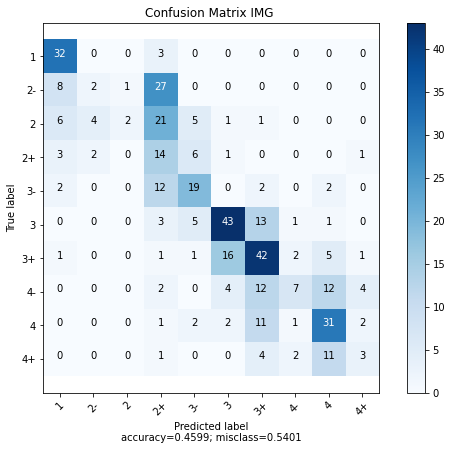

<Figure size 432x288 with 0 Axes>

In [ ]:
import sklearn.metrics as metrics
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
fig = plot_confusion_matrix(cm,
                      target_names = classi,
                      normalize    = False,
                      title        = "Confusion Matrix IMG ")
plt.savefig(os.path.join(path+'weights/CM_{}_{}.pdf'.format(immgs,cnn))) 




##PLOT CONFUSION MATRIX PER CIASCUNA SERIE DEL CALCIO 

In [ ]:
import sklearn.metrics as metrics
from functools import reduce
#serie 0
cm0 = metrics.confusion_matrix(y_true=test_array_s0, y_pred=pred_array_s0)
fig = plot_confusion_matrix(cm0,
                      target_names = reduce(np.union1d, (pred_array_s0, test_array_s0)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 0 ")
plt.savefig(os.path.join(path+'weights/CM_serie0_{}_{}.pdf'.format(immgs,cnn))) 

#serie 1
cm1 = metrics.confusion_matrix(y_true=test_array_s1, y_pred=pred_array_s1)
fig = plot_confusion_matrix(cm1,
                      target_names = reduce(np.union1d, (pred_array_s1, test_array_s1)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 1 ")
plt.savefig(os.path.join(path+'weights/CM_serie1_{}_{}.pdf'.format(immgs,cnn))) 

#serie 2
cm2 = metrics.confusion_matrix(y_true=test_array_s2, y_pred=pred_array_s2)
fig = plot_confusion_matrix(cm2,
                      target_names = reduce(np.union1d, (pred_array_s2, test_array_s2)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 2 ")
plt.savefig(os.path.join(path+'weights/CM_serie2_{}_{}.pdf'.format(immgs,cnn))) 

#serie 3
cm3 = metrics.confusion_matrix(y_true=test_array_s3, y_pred=pred_array_s3)
fig = plot_confusion_matrix(cm3,
                      target_names = reduce(np.union1d, (pred_array_s3, test_array_s3)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 3 ")
plt.savefig(os.path.join(path+'weights/CM_serie3_{}_{}.pdf'.format(immgs,cnn))) 

#serie 4
cm4 = metrics.confusion_matrix(y_true=test_array_s4, y_pred=pred_array_s4)
fig = plot_confusion_matrix(cm4,
                      target_names = reduce(np.union1d, (pred_array_s4, test_array_s4)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 4 ")
plt.savefig(os.path.join(path+'weights/CM_serie4_{}_{}.pdf'.format(immgs,cnn))) 

#serie 5
cm5 = metrics.confusion_matrix(y_true=test_array_s5, y_pred=pred_array_s5)
fig = plot_confusion_matrix(cm5,
                      target_names = reduce(np.union1d, (pred_array_s5, test_array_s5)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 5 ")
plt.savefig(os.path.join(path+'weights/CM_serie5_{}_{}.pdf'.format(immgs,cnn))) 

#serie 6
cm6 = metrics.confusion_matrix(y_true=test_array_s6, y_pred=pred_array_s6)
fig = plot_confusion_matrix(cm6,
                      target_names = reduce(np.union1d, (pred_array_s6, test_array_s6)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 6 ")
plt.savefig(os.path.join(path+'weights/CM_serie6_{}_{}.pdf'.format(immgs,cnn))) 

#serie 7
cm7 = metrics.confusion_matrix(y_true=test_array_s7, y_pred=pred_array_s7)
fig = plot_confusion_matrix(cm7,
                      target_names = reduce(np.union1d, (pred_array_s7, test_array_s7)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 7 ")
plt.savefig(os.path.join(path+'weights/CM_serie7_{}_{}.pdf'.format(immgs,cnn))) 

#serie 8
cm8 = metrics.confusion_matrix(y_true=test_array_s8, y_pred=pred_array_s8)
fig = plot_confusion_matrix(cm8,
                      target_names = reduce(np.union1d, (pred_array_s8, test_array_s8)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 8 ")
plt.savefig(os.path.join(path+'weights/CM_serie8_{}_{}.pdf'.format(immgs,cnn))) 

#serie 9 
cm9 = metrics.confusion_matrix(y_true=test_array_s9, y_pred=pred_array_s9)
fig = plot_confusion_matrix(cm9,
                      target_names = reduce(np.union1d, (pred_array_s9, test_array_s9)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 9 ")
plt.savefig(os.path.join(path+'weights/CM_serie9_{}_{}.pdf'.format(immgs,cnn))) 

#serie 10
cm10 = metrics.confusion_matrix(y_true=test_array_s10, y_pred=pred_array_s10)
fig = plot_confusion_matrix(cm10,
                      target_names = reduce(np.union1d, (pred_array_s10, test_array_s10)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 10 ")
plt.savefig(os.path.join(path+'weights/CM_serie10_{}_{}.pdf'.format(immgs,cnn))) 

#serie 11
cm11 = metrics.confusion_matrix(y_true=test_array_s11, y_pred=pred_array_s11)
fig = plot_confusion_matrix(cm11,
                      target_names = reduce(np.union1d, (pred_array_s11, test_array_s11)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 11 ")
plt.savefig(os.path.join(path+'weights/CM_serie11_{}_{}.pdf'.format(immgs,cnn))) 

#serie 12
cm12 = metrics.confusion_matrix(y_true=test_array_s12, y_pred=pred_array_s12)
fig = plot_confusion_matrix(cm12,
                      target_names = reduce(np.union1d, (pred_array_s12, test_array_s12)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 12 ")
plt.savefig(os.path.join(path+'weights/CM_serie12_{}_{}.pdf'.format(immgs,cnn))) 

## CRAMER V CORRELATION

In [ ]:
#PRIMA VERSIONE
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(y_test, y_pred)
print("cramer correlation tra predizioni delle classi, e le classi effettive")
cramer1 = cramers_v(confusion_matrix.values)
print(cramer1)

confusion_matrix2 = pd.crosstab(y_test_series, y_pred)
print("cramer correlation tra predizioni delle classi e le ground thruth di shotgun series")
cramer2 = cramers_v(confusion_matrix2.values)
print(cramer2)

cramer correlation tra predizioni delle classi, e le classi effettive
0.467809121705438
cramer correlation tra predizioni delle classi e le ground thruth di shotgun series
0.6224385175398571


In [ ]:
#SECONDA VERSIONE.        https://www.youtube.com/watch?v=eTnLTJer_Oo
contTable = pd.crosstab(y_test_series, y_pred)
print(contTable)

!pip install researchpy

import researchpy

crosstab, res = researchpy.crosstab(pd.Series(y_test_series), pd.Series(y_pred), test='chi-square')
print("\n{}".format(res))

df = min(contTable.shape[0], contTable.shape[1]) - 1
print("\ndf = {}".format(df))

V = res.iloc[2,1]
print("V = {}".format(V))

if df == 1:
    if V < 0.10:
        qual = 'negligible'
    elif V < 0.30:
        qual = 'small'
    elif V < 0.50:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 2:
    if V < 0.07:
        qual = 'negligible'
    elif V < 0.21:
        qual = 'small'
    elif V < 0.35:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 3:
    if V < 0.06:
        qual = 'negligible'
    elif V < 0.17:
        qual = 'small'
    elif V < 0.29:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 4:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.15:
        qual = 'small'
    elif V < 0.25:
        qual = 'medium'
    else:
        qual = 'large'
else:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.13:
        qual = 'small'
    elif V < 0.22:
        qual = 'medium'
    else:
        qual = 'large'

print("\nquality classification of the correlation is:   {}".format(qual))


To indicate the strength of the association between two nominal variables, Cramér's V (Cramér, 1946) is often used.

As for the interpretation for Cramér's V various rules of thumb exist but one of them is from Cohen (1988, pp. 222, 224, 225) who let's the interpretation depend on the degrees of freedom, shown in the table below.

|df*|negligible|small|medium|large|
|-------|---|---|---|---|
|1|0 < .10|.10 < .30|.30 < .50|.50 or more|
|2|0 < .07|.07 < .21|.21 < .35|.35 or more|
|3|0 < .06|.06 < .17|.17 < .29|.29 or more|
|4|0 < .05|.05 < .15|.15 < .25|.25 or more|
|5|0 < .05|.05 < .13|.13 < .22|.22 or more|

The degrees of freedom (df*) is for Cramér's V the minimum of the number of rows, or number of columns, then minus one.

Lets see how to obtain Cramér's V with Python, using an example.




**A SECONDA DEI RISULTATI E CONFRONTANDOLI CON LA TABELLA RIUSCIAMO A CAPIRE L'INTENSITA' DEL BIAS TRA DIVERSE VARIABILI**

# T-SNE  & PCA


## Spiegazioni e Link Utili

***(t-SNE)*** t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. It maps multi-dimensional data to two or more dimensions suitable for human observation. With help of the t-SNE algorithms, you may have to plot fewer exploratory data analysis plots next time you work with high dimensional data.

[Link utile ](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)

***(PCA) Principal Component Analysis***
Lʹanalisi delle componenti principali (detta pure PCA oppure CPA) è una tecnica utilizzata nell’ambito della statistica multivariata per la semplificazione dei dati d’origine.
Lo scopo primario di questa tecnica è la riduzione di un numero più o meno elevato di variabili (rappresentanti altrettante caratteristiche del fenomeno analizzato) in alcune variabili latenti. Ciò avviene tramite una trasformazione lineare delle variabili che proietta quelle originarie in un nuovo sistema cartesiano nel quale le variabili vengono ordinate in ordine decrescente di varianza: pertanto, la variabile con maggiore varianza viene proiettata sul primo asse, la seconda sul secondo asse e così via. La riduzione della complessità avviene limitandosi ad analizzare le principali (per varianza) tra le nuove variabili.
Diversamente da altre trasformazioni (lineari) di variabili praticate nellʹambito della statistica, in questa tecnica sono gli stessi dati che determinano i vettori di trasformazione.
[Step By Step](https://www.youtube.com/watch?v=FgakZw6K1QQ)

[Link Utile](https://www.analyticsvidhya.com/blog/2020/12/an-end-to-end-comprehensive-guide-for-pca/) 

***Parametri del TSNE***
1. **n_components** int, default=2 - Dimension of the embedded space.

2. **perplexityfloat, default=30.0** - The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results.

3. **early_exaggeration float, default=12.0**
Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.

4. **learning_ratefloat, default=200.0** The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

5. **n_iterint, default=1000**
Maximum number of iterations for the optimization. Should be at least 250.

6. **n_iter_without_progressint, default=300**
Maximum number of iterations without progress before we abort the optimization, used after 250 initial iterations with early exaggeration. Note that progress is only checked every 50 iterations so this value is rounded to the next multiple of 50.

7. **metricstr or callable, default=’euclidean’**
The metric to use when calculating distance between instances in a feature array. If metric is a string, it must be one of the options allowed by scipy.spatial.distance.pdist for its metric parameter, or a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS. If metric is “precomputed”, X is assumed to be a distance matrix. Alternatively, if metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. The callable should take two arrays from X as input and return a value indicating the distance between them. The default is “euclidean” which is interpreted as squared euclidean distance.

8. **init{‘random’, ‘pca’} or ndarray of shape(n_samples, n_components), default=’random’**
Initialization of embedding. Possible options are ‘random’, ‘pca’, and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.

9. **verboseint, default=0** Verbosity level.

10. **random_stateint, RandomState instance or None, default=None** Determines the random number generator. Pass an int for reproducible results across multiple function calls. Note that different initializations might result in different local minima of the cost function. See :term: Glossary <random_state>.

11. **methodstr, default=’barnes_hut’**
By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.

12. **n_jobsint, default=None**
The number of parallel jobs to run for neighbors search. This parameter has no impact when metric="precomputed" or (metric="euclidean" and method="exact"). None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.


[scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[misread-tsne](https://distill.pub/2016/misread-tsne/)

[altro modo spiegato anche meglio](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)
